In [16]:
import copy
import datetime
import pickle
import itertools
import time
import functools

import simpy
import numpy as np
import networkx as nx
import pandas as pd
import geopandas as gpd
import shapely.geometry
import matplotlib.pyplot as plt

import opentnsim.core

In [17]:
with open('experiment3-graph.pickle', 'rb') as f:
    graph = pickle.load(f)

In [18]:
def generate_route_alternatives(graph):
    """generate a list of dictionaries, where each dictionary is a route alternatives with name, waypoints and a route."""
    route_alternatives = [
        {
            "name": "direct",
            "waypoints": ['A', 'D', 'H']
        },
        {
            "name": "redirect",
            "waypoints": ['A', 'H', 'D']
        },
    ]


    for alternative in route_alternatives:
        route = []    
        waypoints = alternative["waypoints"]
        for a, b in zip(waypoints[:-1], waypoints[1:]):
            path = nx.shortest_path(graph, a, b)
            route.extend(path)

        route = [
            k 
            for (k, g)
            in itertools.groupby(route)
        ]


        alternative["route"] = route
    return route_alternatives

route_alternatives = generate_route_alternatives(graph)
route_alternatives

[{'name': 'direct',
  'waypoints': ['A', 'D', 'H'],
  'route': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']},
 {'name': 'redirect',
  'waypoints': ['A', 'H', 'D'],
  'route': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'G', 'F', 'E', 'D']}]

In [19]:
def generate_engine_alternatives():
    """generate a list of dictionaries, where each dictionary is a engine order setting."""
    engine_orders = [0.5, 0.6, 0.7, 0.8, 0.9]
    engine_alternatives = []
    for engine_order in engine_orders:
        alternative = {"engine_order": engine_order} 
        engine_alternatives.append(alternative)
    return engine_alternatives

generate_engine_alternatives()
    

[{'engine_order': 0.5},
 {'engine_order': 0.6},
 {'engine_order': 0.7},
 {'engine_order': 0.8},
 {'engine_order': 0.9}]

In [20]:
def generate_all_alternatives(graph):
    """generate a pandas dataframe with alternatives for green routing and green steaming"""
    alternatives = []
    engine_alternatives = generate_engine_alternatives()
    for engine_alternative in engine_alternatives:
        for route_alternative in generate_route_alternatives(graph):
            alternative = copy.deepcopy(route_alternative)
            alternative.update(engine_alternative)
            alternatives.append(alternative)
            
        
    alternatives_df = pd.DataFrame(alternatives)
    # not the direct route
    alternatives_df['green_routing'] = alternatives_df['name'] == 'redirect'
    # not the maximum power
    highest_engine_order = engine_alternatives[-1]["engine_order"]
    alternatives_df['green_steaming'] = alternatives_df['engine_order'] < highest_engine_order
    return alternatives_df


alternatives_df = generate_all_alternatives(graph)
alternatives_df

,name,waypoints,route,engine_order,green_routing,green_steaming
0,direct,"[A, D, H]","[A, B, C, D, E, F, G, H]",0.5,False,True
1,redirect,"[A, H, D]","[A, B, C, D, E, F, G, H, G, F, E, D]",0.5,True,True
2,direct,"[A, D, H]","[A, B, C, D, E, F, G, H]",0.6,False,True
3,redirect,"[A, H, D]","[A, B, C, D, E, F, G, H, G, F, E, D]",0.6,True,True
4,direct,"[A, D, H]","[A, B, C, D, E, F, G, H]",0.7,False,True
5,redirect,"[A, H, D]","[A, B, C, D, E, F, G, H, G, F, E, D]",0.7,True,True
6,direct,"[A, D, H]","[A, B, C, D, E, F, G, H]",0.8,False,True
7,redirect,"[A, H, D]","[A, B, C, D, E, F, G, H, G, F, E, D]",0.8,True,True
8,direct,"[A, D, H]","[A, B, C, D, E, F, G, H]",0.9,False,False
9,redirect,"[A, H, D]","[A, B, C, D, E, F, G, H, G, F, E, D]",0.9,True,False


# Load the network from a file
We have drawn a notebook, similar to the Port of Rotterdam. The goal is to have a ship "Blue" moving from A to B, wait at B, then the ship will move from B to C. 

When ship "Green" starts, it should notice that B is occupied. Ship "Green" will have to decide whether to sail slower or to adapt it's route by going from A to C to B, to avoid waiting for ship "Blue"

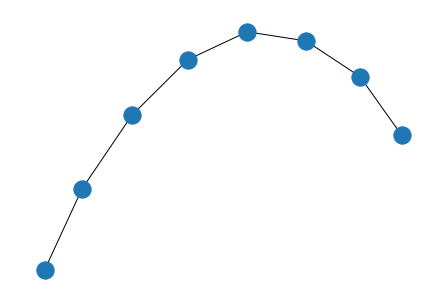

In [21]:
nx.draw(graph)

In [22]:
def run_simulation(geometry, route, graph, engine_order=0.8):
    Vessel = type(
        'Vessel', 
        (
            opentnsim.core.Identifiable, 
            opentnsim.core.Movable, 
            opentnsim.core.Routeable, 
            opentnsim.core.VesselProperties,
            opentnsim.energy.ConsumesEnergy,
            opentnsim.core.ExtraMetadata
        ), 
        {}
    )

    max_v = 5.0
    P_installed = 1750
    
    data_vessel = {
        "env": None,
        "name": "NausBot",
        "route": None,
        "geometry": geometry,
        "type": "Va",
        "B": 11.4,
        "L": 110,
        'P_installed': P_installed, 
        'L_w': 3, 
        "T": 3.5,
        'C_year': 1997,
        "v": engine_order * max_v
    
    } 
    vessel = Vessel(**data_vessel)
    
        

    # start simpy environment (specify the start time and add the graph to the environment)
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.FG = graph

    # add environment to the vessel, and specify the vessels route and current location (beginning of the path)
    vessel.env = env
    vessel.route = route
    
    # specify the process that needs to be executed
    env.process(vessel.move())

    # start the simulation
    env.run()

    #Determine trip time
    start_time = simulation_start.timestamp()
        

    end = vessel.log["Timestamp"][-1]

    end_time = end.timestamp()

    energycalculation = opentnsim.energy.EnergyCalculation(graph, vessel)
    energycalculation.calculate_energy_consumption()

    # create dataframe from energy calculation computation
    energy_df = pd.DataFrame.from_dict(energycalculation.energy_use)

    return end_time-start_time, end, energy_df, vessel




In [29]:

def add_kpi(alternatives_df, berth_occupied, graph):

    result = alternatives_df.copy()
    for idx, row in alternatives_df.iterrows():
        current_node = row['route'][0]
        geometry = graph.nodes[current_node]['geometry']
        route = row['route']
        graph = graph
        engine_order = row['engine_order']
        duration, eta, energy_df, vessel = run_simulation(geometry=geometry, route=route, graph=graph, engine_order=engine_order)

        energy_sum = energy_df.sum(axis=0, numeric_only=True) 
        result.at[idx, 'duration'] = duration
        result.at[idx, 'total_energy'] = energy_sum['total_energy']
        result.at[idx, 'total_emission_CO2'] = energy_sum['total_emission_CO2']
        result.at[idx, 'total_emission_PM10'] = energy_sum['total_emission_PM10']
        result.at[idx, 'total_emission_NOX'] = energy_sum['total_emission_NOX']
        result.at[idx, 'total_diesel_consumption_ICE_vol'] = energy_sum['total_diesel_consumption_ICE_vol']
        result.at[idx, 'vessel'] = vessel
    # TODO: replace with a timeout on_pass_edge 
    if berth_occupied:    
        # add waiting time to direct routes
        result.loc[result['name'] == 'direct', 'duration']  += 10

    return result
    
berth_occupied = True
    
kpi_df = add_kpi(alternatives_df, berth_occupied=berth_occupied, graph=graph)


In [31]:
# best option from duration perspective
kpi_df.sort_values('total_emission_CO2')

# result.loc[result['duration'].argmin()], result.loc[result['total_emission_CO2'].argmin()]

,name,waypoints,route,engine_order,green_routing,green_steaming,duration,total_energy,total_emission_CO2,total_emission_PM10,total_emission_NOX,total_diesel_consumption_ICE_vol,vessel
6,direct,"[A, D, H]","[A, B, C, D, E, F, G, H]",0.8,False,True,28.343476,1.997098,1480.550456,0.693126,20.294804,0.000603,<__main__.Vessel object at 0x14e59daf0>
0,direct,"[A, D, H]","[A, B, C, D, E, F, G, H]",0.5,False,True,38.524477,1.940440,1499.051698,0.819607,22.220594,0.000610,<__main__.Vessel object at 0x14dfbc100>
2,direct,"[A, D, H]","[A, B, C, D, E, F, G, H]",0.6,False,True,33.566954,2.226643,1675.689238,0.817459,23.403900,0.000682,<__main__.Vessel object at 0x14e5aea30>
8,direct,"[A, D, H]","[A, B, C, D, E, F, G, H]",0.9,False,False,26.253120,2.383533,1719.537317,0.772139,23.300102,0.000700,<__main__.Vessel object at 0x14dd44760>
4,direct,"[A, D, H]","[A, B, C, D, E, F, G, H]",0.7,False,True,30.018744,2.533778,1862.190895,0.853176,25.279272,0.000758,<__main__.Vessel object at 0x14dfd47c0>
7,redirect,"[A, H, D]","[A, B, C, D, E, F, G, H, G, F, E, D]",0.8,True,True,29.157755,3.174883,2353.702139,1.101896,32.263625,0.000958,<__main__.Vessel object at 0x14e1e0bb0>
1,redirect,"[A, H, D]","[A, B, C, D, E, F, G, H, G, F, E, D]",0.5,True,True,45.827945,3.084811,2383.114363,1.302968,35.325144,0.000970,<__main__.Vessel object at 0x14dfee280>
3,redirect,"[A, H, D]","[A, B, C, D, E, F, G, H, G, F, E, D]",0.6,True,True,37.992267,3.539801,2663.923536,1.299553,37.206302,0.001085,<__main__.Vessel object at 0x14e64a9a0>
9,redirect,"[A, H, D]","[A, B, C, D, E, F, G, H, G, F, E, D]",0.9,True,False,25.861340,3.789216,2733.630847,1.227506,37.041289,0.001113,<__main__.Vessel object at 0x14ddec760>
5,redirect,"[A, H, D]","[A, B, C, D, E, F, G, H, G, F, E, D]",0.7,True,True,32.379044,4.028069,2960.414062,1.356335,40.187670,0.001205,<__main__.Vessel object at 0x14e06e310>
